In [42]:
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

url = "https://en.wikipedia.org/wiki/List_of_countries_by_level_of_military_equipment"
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

content = soup.find(id="mw-content-text")
tbody_elements = content.find_all('tbody')
country_data = []

# Loop through each <tbody> to find the relevant rows
for tbody in tbody_elements:
    rows = tbody.find_all('tr')
    
    for row in rows:
        # Extract the first column which contains the country name
        country_name_cell = row.find('a')
        if country_name_cell:
            country_name = country_name_cell.text.strip()
            
            # Extract the numerical data from the remaining <td> elements
            data_cells = row.find_all('td')[1:]  # Skip the first <td> (country name)
            row_data = [td.text.strip() for td in data_cells if td.text.strip() != ""]
            
            # Append the country name and data as a list
            if row_data:
                country_data.append([country_name] + row_data)

# Remove the first 3 faulty arrays
if len(country_data) > 3:
    country_data = country_data[3:]

# Step 3: Fix the issue with the 3rd element containing a dot '.'
for entry in country_data:
    if len(entry) > 2 and '.' in entry[2]:
        # Combine the 2nd and 3rd elements into a float
        entry[1] = str(float(entry[1] + entry[2]))
        # Remove the 3rd element
        entry.pop(2)

# Remove all table data that isnt the military capabilities of the 171 countries
country_data = country_data[:171]

# remove all citations
for entry in country_data:
    if entry[2] == '[j]':
        entry.pop(2)

print(country_data[-8])

['United States', '877', '4645', '11', '42', '12', '75', '23', '0', '68', '0', '3368', '867', '5244', '141', '[7][15][16]']


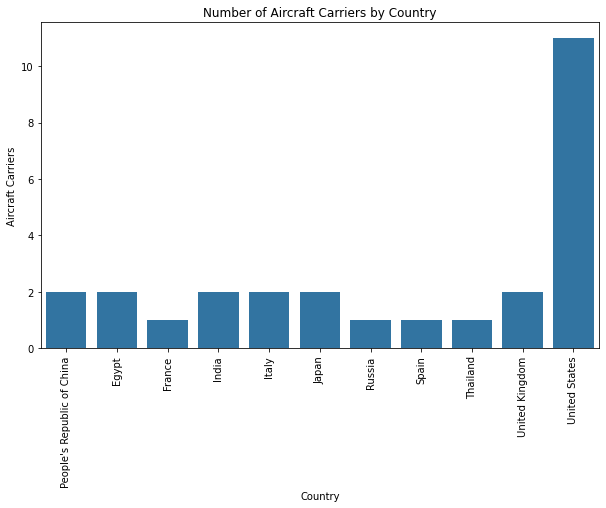

In [45]:
# Filter out countries with zero aircraft carriers (4th element)
countries = []
aircraft_carriers = []

for entry in country_data:
    if len(entry) > 3 and entry[3].isdigit() and int(entry[3]) > 0:
        countries.append(entry[0])
        aircraft_carriers.append(int(entry[3]))

# Step 5: Create a DataFrame
df = pd.DataFrame({
    'Country': countries,
    'Aircraft Carriers': aircraft_carriers
})

# Step 6: Plot the bar chart using Seaborn
plt.figure(figsize=(10,6))
sns.barplot(x='Country', y='Aircraft Carriers', data=df)
plt.xticks(rotation=90)  # Rotate country names for better readability
plt.title('Number of Aircraft Carriers by Country')
plt.show()
